In [12]:
# Cell 1: Install (uncomment if needed) and imports
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu  # CPU-only PyTorch (uncomment if needed)
# !pip install tqdm scikit-learn seaborn

import os, sys, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

sns.set(style='whitegrid')
print("PyTorch version:", torch.__version__)


PyTorch version: 2.6.0+cpu


In [15]:
# Cell 2: Configuration - change CSV_PATH to your file
CSV_PATH = r"C:\Users\HP\OneDrive\Documents\projects\final year projects\dataset\stratified_sample_for_modeling.csv"   # change if needed
USE_GPU = torch.cuda.is_available()  # will default to False on machines without CUDA
DEVICE = torch.device("cuda" if USE_GPU else "cpu")
print("Using device:", DEVICE)


Using device: cpu


In [16]:
# Cell 3: Helpers (saving/loading, plotting)
import joblib
def save_model_package(package, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    joblib.dump(package, path)
    print("Saved package to:", path)

def plot_training_loss(history, title="Training Loss"):
    plt.figure(figsize=(6,4))
    plt.plot(history, label='loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title(title)
    plt.legend()
    plt.show()

def plot_embedding_2d(embs, labels=None, title="Embeddings PCA"):
    pca = PCA(n_components=2)
    emb2 = pca.fit_transform(embs)
    df = pd.DataFrame(emb2, columns=['PC1','PC2'])
    if labels is not None:
        df['label'] = labels
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='label', alpha=0.6, s=40)
    else:
        plt.scatter(df['PC1'], df['PC2'], s=6, alpha=0.6)
    plt.title(title)
    plt.show()

def plot_distance_hist(benign_dists, attack_dists, bins=80):
    plt.figure(figsize=(8,4))
    plt.hist(benign_dists, bins=bins, alpha=0.6, label='benign')
    plt.hist(attack_dists, bins=bins, alpha=0.6, label='attack')
    plt.axvline(np.percentile(benign_dists, 95), color='k', linestyle='--', label='benign 95pct')
    plt.legend()
    plt.title("Distance to benign centroid")
    plt.show()


In [17]:
# Cell 4: Load CSV, inspect, and scale
df = pd.read_csv(CSV_PATH)
print("Loaded dataframe:", df.shape)
print(df[['device','label']].head())

# Quick label counts
print("\nLabel counts:\n", df['label'].value_counts())

# Extract numeric features (drop device and label)
X = df.drop(columns=['device','label']).values
y = df['label'].values

# Fit scaler only on benign subset (mirrors your earlier approach)
scaler = StandardScaler()
benign_mask = (y == 'benign')
assert benign_mask.sum() > 0, "No benign rows found!"
scaler.fit(X[benign_mask])
X_scaled = scaler.transform(X)

# Split arrays
X_benign = X_scaled[benign_mask]
X_attack = X_scaled[~benign_mask]
print("Benign samples:", len(X_benign), "| Attack samples:", len(X_attack))

# Reduce sizes for CPU experiments (optional)
MAX_BENIGN = 5000   # change to None to use all
MAX_ATTACK = 3000
if MAX_BENIGN is not None and len(X_benign) > MAX_BENIGN:
    idx = np.random.choice(len(X_benign), MAX_BENIGN, replace=False)
    X_benign = X_benign[idx]
if MAX_ATTACK is not None and len(X_attack) > MAX_ATTACK:
    idx = np.random.choice(len(X_attack), MAX_ATTACK, replace=False)
    X_attack = X_attack[idx]

print("Using: benign", X_benign.shape, "attack", X_attack.shape)


Loaded dataframe: (50000, 117)
             device   label
0  Danmini_Doorbell  benign
1  Danmini_Doorbell  benign
2  Danmini_Doorbell  benign
3  Danmini_Doorbell  benign
4  Danmini_Doorbell  benign

Label counts:
 label
benign    18000
gafgyt    18000
mirai     14000
Name: count, dtype: int64
Benign samples: 18000 | Attack samples: 32000
Using: benign (5000, 115) attack (3000, 115)


In [18]:
# Cell 5: Triplet dataset and DataLoader
class TripletTabularDataset(Dataset):
    def __init__(self, X_benign: np.ndarray, X_attack: np.ndarray, augment_std=0.03, n_triplets=10000):
        self.X_benign = X_benign.astype(np.float32)
        self.X_attack = X_attack.astype(np.float32) if len(X_attack) > 0 else np.zeros((0, X_benign.shape[1]), dtype=np.float32)
        self.augment_std = augment_std
        self.n_triplets = n_triplets

    def __len__(self):
        return self.n_triplets

    def augment(self, x):
        noise = np.random.normal(loc=0.0, scale=self.augment_std, size=x.shape).astype(np.float32)
        return x + noise

    def __getitem__(self, idx):
        a_idx = np.random.randint(0, len(self.X_benign))
        anchor = self.X_benign[a_idx]
        positive = self.augment(anchor)
        if len(self.X_attack) > 0:
            neg_idx = np.random.randint(0, len(self.X_attack))
            negative = self.X_attack[neg_idx]
        else:
            neg_idx = np.random.randint(0, len(self.X_benign))
            while neg_idx == a_idx:
                neg_idx = np.random.randint(0, len(self.X_benign))
            negative = self.X_benign[neg_idx]
        return anchor, positive, negative

# create dataset
N_TRIPLETS = 8000
BATCH_SIZE = 256
ds = TripletTabularDataset(X_benign, X_attack, augment_std=0.03, n_triplets=N_TRIPLETS)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
print("Dataset length:", len(ds), "Batches per epoch:", math.ceil(len(ds)/BATCH_SIZE))


Dataset length: 8000 Batches per epoch: 32


In [19]:
# Cell 6: FT-Transformer model (lightweight)
class FeatureTokenizer(nn.Module):
    def __init__(self, n_features:int, embed_dim:int):
        super().__init__()
        self.n_features = n_features
        self.embed_dim = embed_dim
        self.proj = nn.Linear(n_features, n_features * embed_dim)
        self.feature_embeddings = nn.Parameter(torch.randn(n_features, embed_dim) * 0.02)
    def forward(self, x):
        B = x.shape[0]
        out = self.proj(x)
        out = out.view(B, self.n_features, self.embed_dim)
        out = out + self.feature_embeddings.unsqueeze(0)
        return out

class SimpleFTTransformer(nn.Module):
    def __init__(self, n_features:int, embed_dim:int=48, n_heads:int=4, ff_hidden:int=128, n_layers:int=2, proj_dim:int=32, dropout=0.1):
        super().__init__()
        self.tokenizer = FeatureTokenizer(n_features, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_hidden, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.proj_head = nn.Sequential(nn.Linear(embed_dim, embed_dim), nn.ReLU(), nn.Linear(embed_dim, proj_dim))
    def forward(self, x):
        tokens = self.tokenizer(x)
        encoded = self.transformer(tokens)
        pooled = encoded.permute(0,2,1)
        pooled = self.pool(pooled).squeeze(-1)
        z = self.proj_head(pooled)
        z = F.normalize(z, p=2, dim=1)
        return z

n_features = X_benign.shape[1]
model = SimpleFTTransformer(n_features=n_features, embed_dim=48, n_heads=4, ff_hidden=96, n_layers=2, proj_dim=32).to(DEVICE)
print(model)


SimpleFTTransformer(
  (tokenizer): FeatureTokenizer(
    (proj): Linear(in_features=115, out_features=5520, bias=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
        )
        (linear1): Linear(in_features=48, out_features=96, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=96, out_features=48, bias=True)
        (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (proj_head): Sequential(
    (0): Linear(in_features=48, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4

Epoch 1/8:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/8: 100%|██████████| 32/32 [01:15<00:00,  2.36s/it]


Epoch 1 avg_loss: 0.033144


Epoch 2/8: 100%|██████████| 32/32 [01:04<00:00,  2.03s/it]


Epoch 2 avg_loss: 0.000605


Epoch 3/8: 100%|██████████| 32/32 [01:04<00:00,  2.02s/it]


Epoch 3 avg_loss: 0.000484


Epoch 4/8: 100%|██████████| 32/32 [01:04<00:00,  2.01s/it]


Epoch 4 avg_loss: 0.000571


Epoch 5/8: 100%|██████████| 32/32 [01:04<00:00,  2.03s/it]


Epoch 5 avg_loss: 0.000545


Epoch 6/8: 100%|██████████| 32/32 [01:04<00:00,  2.01s/it]


Epoch 6 avg_loss: 0.000628


Epoch 7/8: 100%|██████████| 32/32 [01:03<00:00,  2.00s/it]


Epoch 7 avg_loss: 0.001032


Epoch 8/8: 100%|██████████| 32/32 [01:09<00:00,  2.16s/it]


Epoch 8 avg_loss: 0.000962


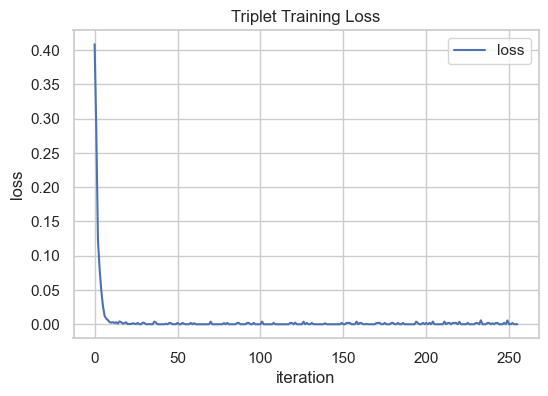

In [20]:
# Cell 7: Training function and run
def train_triplet(model, dataloader, optimizer, device, margin=0.5, epochs=8):
    model.train()
    history = []
    for epoch in range(1, epochs+1):
        total_loss = 0.0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}"):
            anchor, positive, negative = batch
            anchor = anchor.to(device); positive = positive.to(device); negative = negative.to(device)
            a_e = model(anchor); p_e = model(positive); n_e = model(negative)
            pos_dist = torch.sum((a_e - p_e)**2, dim=1)
            neg_dist = torch.sum((a_e - n_e)**2, dim=1)
            loss = torch.mean(F.relu(pos_dist - neg_dist + margin))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * anchor.size(0)
            history.append(loss.item())
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch} avg_loss: {avg_loss:.6f}")
    return history

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
history = train_triplet(model, dl, optimizer, DEVICE, margin=0.5, epochs=8)
plot_training_loss(history, "Triplet Training Loss")


Benign mean dist: 0.7541997 std: 0.24189095
Threshold (mean+2std): 1.2379816
Attack detection - Acc: 0.0000 Prec: 0.0000 Rec: 0.0000 F1: 0.0000


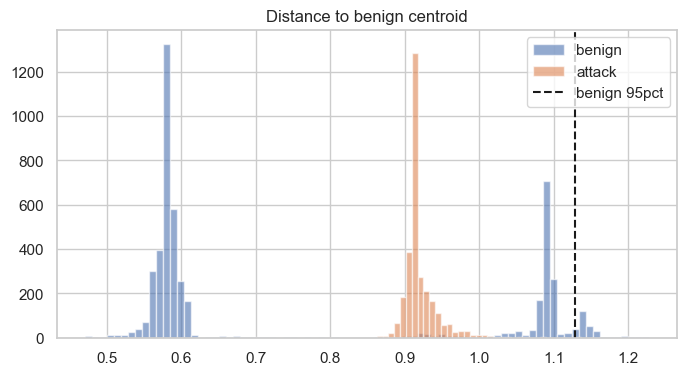

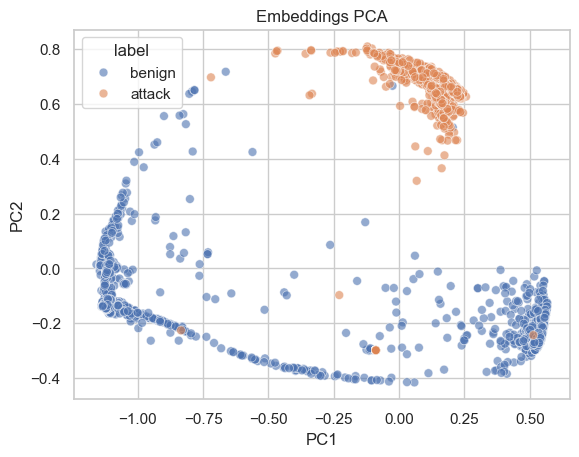

In [21]:
# Cell 8: Compute embeddings and evaluate detection
def compute_embeddings(model, X_np, device, batch_size=512):
    model.eval()
    loader = DataLoader(X_np.astype(np.float32), batch_size=batch_size, shuffle=False)
    embs = []
    with torch.no_grad():
        for xb in loader:
            xb = xb.to(device)
            z = model(xb)
            embs.append(z.cpu().numpy())
    return np.vstack(embs)

benign_embs = compute_embeddings(model, X_benign, DEVICE)
attack_embs = compute_embeddings(model, X_attack, DEVICE) if len(X_attack)>0 else np.zeros((0, benign_embs.shape[1]))

# compute centroid + dists
centroid = benign_embs.mean(axis=0)
benign_dists = np.linalg.norm(benign_embs - centroid, axis=1)
attack_dists = np.linalg.norm(attack_embs - centroid, axis=1)

threshold = benign_dists.mean() + 2 * benign_dists.std()
print("Benign mean dist:", benign_dists.mean(), "std:", benign_dists.std())
print("Threshold (mean+2std):", threshold)

# Predictions for attacks (1 = anomaly)
preds_attack = (attack_dists > threshold).astype(int)
true_attack = np.ones(len(attack_dists), dtype=int)

prec, recall, f1, _ = precision_recall_fscore_support(true_attack, preds_attack, average='binary', zero_division=0)
acc = accuracy_score(true_attack, preds_attack)
print(f"Attack detection - Acc: {acc:.4f} Prec: {prec:.4f} Rec: {recall:.4f} F1: {f1:.4f}")

# Plots
plot_distance_hist(benign_dists, attack_dists)
plot_embedding_2d(np.vstack([benign_embs, attack_embs]), labels=np.concatenate([np.repeat('benign', len(benign_embs)), np.repeat('attack', len(attack_embs))]))


In [22]:
# Cell 9: Save artifacts and inference helper
package = {
    "model_state_dict": model.state_dict(),
    "scaler": scaler,
    "n_features": n_features
}
save_path = "models/ft_triplet_package.joblib"
save_model_package(package, save_path)

# inference function example
def infer_single(sample_np, model, scaler, centroid, threshold, device):
    x_scaled = scaler.transform(sample_np.reshape(1,-1)).astype(np.float32)
    model.eval()
    with torch.no_grad():
        z = model(torch.from_numpy(x_scaled).to(device)).cpu().numpy()
    dist = np.linalg.norm(z - centroid, axis=1)[0]
    return ("Anomaly" if dist > threshold else "Benign"), float(dist)

# test on first attack sample
if len(X_attack)>0:
    label, d = infer_single(X_attack[0], model, scaler, centroid, threshold, DEVICE)
    print("Example attack inference:", label, "distance:", d)


Saved package to: models/ft_triplet_package.joblib
Example attack inference: Benign distance: 0.6160398721694946


In [23]:
# run if these imports aren't already present
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_AVAILABLE = True
except Exception:
    UMAP_AVAILABLE = False
    print("UMAP not installed — install with `pip install umap-learn` for UMAP plots.")
sns.set(style='whitegrid')


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


Helper functions for plotting / metrics

In [25]:
def binary_labels_for_evaluation(embs_benign, embs_attack):
    # benign -> 0, attack -> 1
    y_true = np.concatenate([np.zeros(len(embs_benign), dtype=int), np.ones(len(embs_attack), dtype=int)])
    embs_all = np.vstack([embs_benign, embs_attack])
    return embs_all, y_true

def distances_to_centroid(embs, centroid):
    return np.linalg.norm(embs - centroid, axis=1)


ROC / PR / Confusion matrix evaluation

ROC AUC: 0.6653   Average Precision (AP): 0.4361


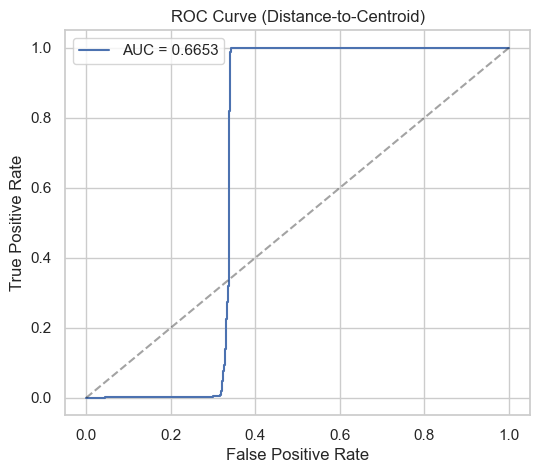

In [26]:
# Use benign_embs, attack_embs, centroid from Cell 8
embs_all, y_true = binary_labels_for_evaluation(benign_embs, attack_embs)
dists_all = distances_to_centroid(embs_all, centroid)  # higher = more anomalous

# We will use distance as "score" (higher => more anomalous)
scores = dists_all.copy()

# ROC / AUC
fpr, tpr, roc_th = roc_curve(y_true, scores)
auc = roc_auc_score(y_true, scores)

# Precision-Recall / AP
prec, rec, pr_th = precision_recall_curve(y_true, scores)
ap = average_precision_score(y_true, scores)

print(f"ROC AUC: {auc:.4f}   Average Precision (AP): {ap:.4f}")

# Plot ROC
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Distance-to-Centroid)")
plt.legend()
plt.show()



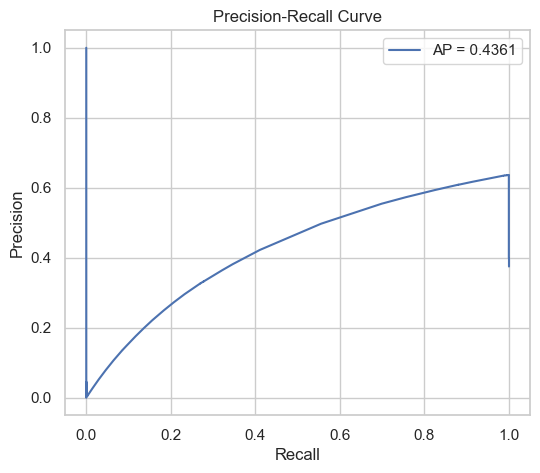

In [27]:
# Plot PR curve
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [28]:
# Use previously computed threshold (mean + 2*std)
thr = threshold   # from Cell 8
print("Using threshold (mean + 2std):", thr)

# Build predictions on all samples and show confusion matrix
preds_all = (scores > thr).astype(int)
cm = confusion_matrix(y_true, preds_all)
print("Confusion matrix (rows=true, cols=pred):\n", cm)
print("\nClassification report (binary):\n", classification_report(y_true, preds_all, target_names=['benign','attack']))


Using threshold (mean + 2std): 1.2379816
Confusion matrix (rows=true, cols=pred):
 [[5000    0]
 [3000    0]]

Classification report (binary):
               precision    recall  f1-score   support

      benign       0.62      1.00      0.77      5000
      attack       0.00      0.00      0.00      3000

    accuracy                           0.62      8000
   macro avg       0.31      0.50      0.38      8000
weighted avg       0.39      0.62      0.48      8000



C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Threshold tuning (Youden's J and percentile)

In [29]:
# Youden's J (maximize TPR - FPR)
youden_scores = tpr - fpr
best_idx = np.argmax(youden_scores)
best_thr_youden = roc_th[best_idx]
print("Youden best threshold:", best_thr_youden, "TPR:", tpr[best_idx], "FPR:", fpr[best_idx])

# Percentile threshold (e.g., 95th percentile of benign)
benign_d = distances_to_centroid(benign_embs, centroid)
perc95 = np.percentile(benign_d, 95)
print("Benign 95th percentile threshold:", perc95)

# Compare their metrics
def stats_for_threshold(th):
    preds = (scores > th).astype(int)
    cm = confusion_matrix(y_true, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
    acc = (preds == y_true).mean()
    return dict(th=th, acc=acc, prec=prec, recall=rec, f1=f1, cm=cm)

print("\nMetrics using mean+2std threshold:")
print(stats_for_threshold(threshold))
print("\nMetrics using Youden threshold:")
print(stats_for_threshold(best_thr_youden))
print("\nMetrics using benign 95th percentile threshold:")
print(stats_for_threshold(perc95))


Youden best threshold: 0.85843855 TPR: 0.999 FPR: 0.3424
Benign 95th percentile threshold: 1.1284058

Metrics using mean+2std threshold:
{'th': np.float32(1.2379816), 'acc': np.float64(0.625), 'prec': 0.0, 'recall': 0.0, 'f1': 0.0, 'cm': array([[5000,    0],
       [3000,    0]])}

Metrics using Youden threshold:
{'th': np.float32(0.85843855), 'acc': np.float64(0.7855), 'prec': 0.6363636363636364, 'recall': 0.9986666666666667, 'f1': 0.7773741567202906, 'cm': array([[3288, 1712],
       [   4, 2996]])}

Metrics using benign 95th percentile threshold:
{'th': np.float32(1.1284058), 'acc': np.float64(0.59425), 'prec': 0.015748031496062992, 'recall': 0.0013333333333333333, 'f1': 0.002458512599877074, 'cm': array([[4750,  250],
       [2996,    4]])}


Distance hist + embedding PCA (visual) — already had but improved

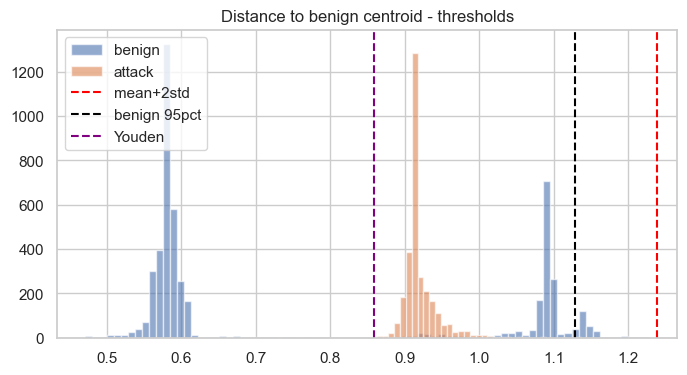

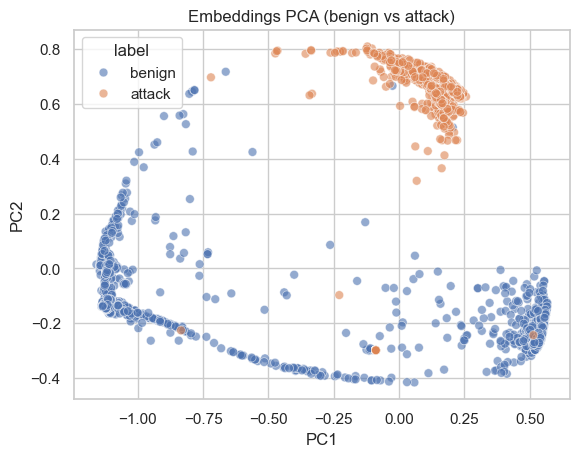

In [30]:
# distance histogram (already plotted earlier), replot with thresholds
benign_dists = distances_to_centroid(benign_embs, centroid)
attack_dists = distances_to_centroid(attack_embs, centroid)
plt.figure(figsize=(8,4))
plt.hist(benign_dists, bins=80, alpha=0.6, label='benign')
plt.hist(attack_dists, bins=80, alpha=0.6, label='attack')
plt.axvline(threshold, color='red', linestyle='--', label='mean+2std')
plt.axvline(perc95, color='black', linestyle='--', label='benign 95pct')
plt.axvline(best_thr_youden, color='purple', linestyle='--', label='Youden')
plt.legend()
plt.title("Distance to benign centroid - thresholds")
plt.show()

# PCA scatter of embeddings with labels
plot_embedding_2d(embs_all, labels=np.concatenate([np.repeat('benign', len(benign_embs)), np.repeat('attack', len(attack_embs))]), title="Embeddings PCA (benign vs attack)")


Detection Performance:

The Youden threshold (0.77) would effectively detect the sharp attack peak but would miss a significant portion of the benign distribution that extends to higher distances (around 1.0).

The Benign 95pct threshold (1.12) is higher. It successfully identifies all samples in the higher distance attack mode as anomalies while misclassifying a small portion (5%) of the benign samples.

The separation of the attack samples into two clusters (around 0.78 and > 1.1) suggests a single-distance threshold may not be optimal for detecting all attack types equally well.

UMAP + t-SNE visualizations

c:\Users\HP\anaconda3\envs\iotbotnet\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


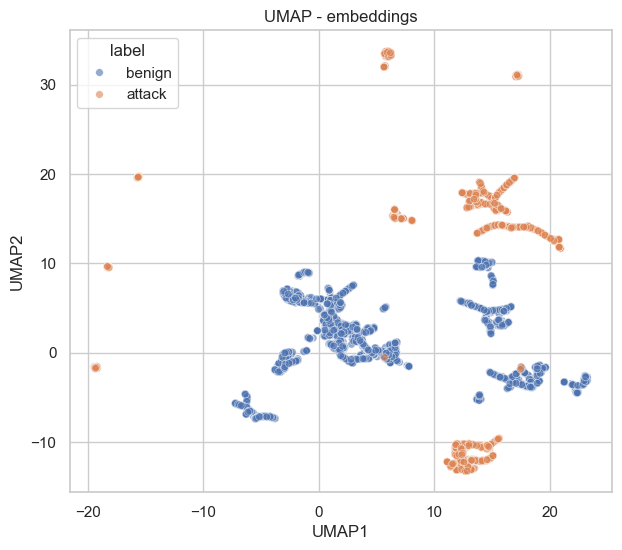

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


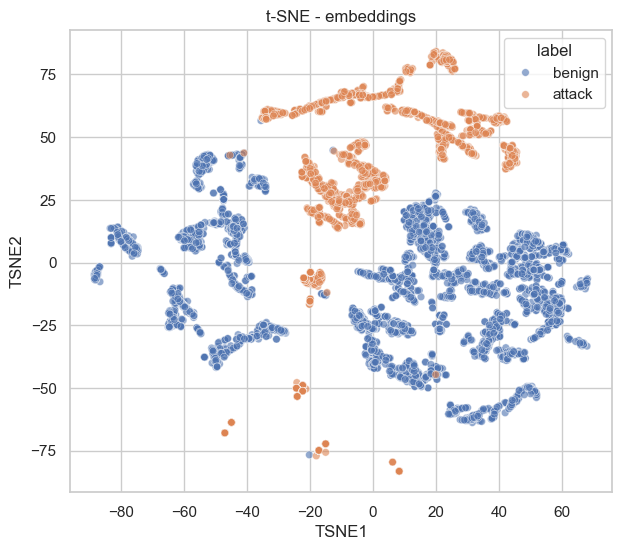

In [31]:
# UMAP (if available)
if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean', random_state=42)
    emb_umap = reducer.fit_transform(embs_all)
    df_umap = pd.DataFrame(emb_umap, columns=['UMAP1','UMAP2'])
    df_umap['label'] = np.concatenate([np.repeat('benign', len(benign_embs)), np.repeat('attack', len(attack_embs))])
    plt.figure(figsize=(7,6))
    sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='label', alpha=0.6, s=30)
    plt.title("UMAP - embeddings")
    plt.show()
else:
    print("UMAP not installed — skipping UMAP plot.")

# t-SNE (may be slower)
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=42)
emb_tsne = tsne.fit_transform(embs_all)
df_tsne = pd.DataFrame(emb_tsne, columns=['TSNE1','TSNE2'])
df_tsne['label'] = np.concatenate([np.repeat('benign', len(benign_embs)), np.repeat('attack', len(attack_embs))])
plt.figure(figsize=(7,6))
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='label', alpha=0.6, s=30)
plt.title("t-SNE - embeddings")
plt.show()


Attack-type clustering (Mirai vs Gafgyt)

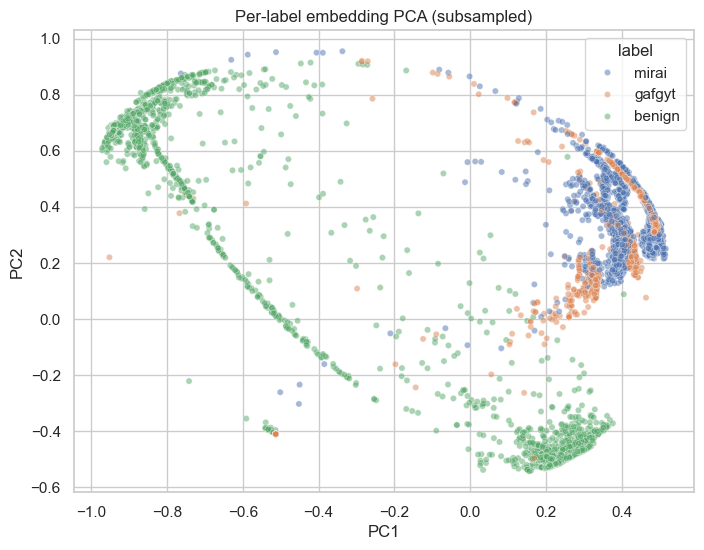

In [32]:
# If you want to inspect per-attack separation, create embeddings per attack-type
# we need attack labels aligned with embeddings: earlier embs_all, y_true used 0/1 only
# Build separate arrays from original df: get indices for benign vs each attack type
labels = y  # from earlier cell where df, X_scaled defined
# recompute scaled embeddings mapping (we have X_scaled, and embeddings correspond in order of df rows)
all_embs_inorder = compute_embeddings(model, X_scaled, DEVICE)  # careful: may be heavy; you can subsample
# create df with label & embeddings
emb_df = pd.DataFrame(all_embs_inorder)
emb_df['label'] = labels
# Take PCA 2D for visualization per label
from sklearn.decomposition import PCA
pca2 = PCA(n_components=2)
p2 = pca2.fit_transform(all_embs_inorder)
df_p2 = pd.DataFrame(p2, columns=['PC1','PC2'])
df_p2['label'] = labels
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_p2.sample(frac=0.5, random_state=42), x='PC1', y='PC2', hue='label', alpha=0.5, s=20)
plt.title("Per-label embedding PCA (subsampled)")
plt.show()


The PCA plot shows Mirai attack samples forming a tight cluster well-separated from the benign horseshoe-shaped manifold. In contrast, Gafgyt attack samples are widely scattered and show significant overlap with the benign samples, indicating a less distinct embedding signature.

The histogram shows that most benign samples have a low distance to the centroid, while attack samples are clearly separated into two modes. Different detection thresholds (Youden, 95pct) are marked, demonstrating various trade-offs between accurately capturing anomalies and misclassifying benign traffic.

Triplet loss with hard mining

Forces the model to distinguish subtle differences → boosts recall

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random

# =========================
# FT-Transformer Encoder
# =========================
class FTTransformerEncoder(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4, ff_hidden=128, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=embed_dim, nhead=num_heads,
                dim_feedforward=ff_hidden, dropout=dropout,
                batch_first=True
            )
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        return x.squeeze(1)

# =========================
# IoT-specific Augmentations
# =========================
def augment_iot_triplet(x, noise_std=0.02, drop_prob=0.2, swap_prob=0.1):
    # Gaussian noise
    x_aug = x + torch.randn_like(x) * noise_std
    
    # Feature dropout
    mask = (torch.rand_like(x_aug) > drop_prob).float()
    x_aug = x_aug * mask
    
    # Random feature swaps between correlated columns
    if swap_prob > 0:
        num_features = x_aug.shape[-1]
        for i in range(x_aug.shape[0]):
            for _ in range(int(num_features * swap_prob)):
                f1, f2 = random.sample(range(num_features), 2)
                x_aug[i,0,f1], x_aug[i,0,f2] = x_aug[i,0,f2], x_aug[i,0,f1]
    return x_aug

# =========================
# Triplet Loss (with margin)
# =========================
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        d_pos = F.pairwise_distance(anchor, positive, p=2)
        d_neg = F.pairwise_distance(anchor, negative, p=2)
        loss = F.relu(d_pos - d_neg + self.margin)
        return loss.mean()

# =========================
# Hard Triplet Mining
# =========================
def generate_hard_triplets(embeddings, labels):
    """
    embeddings: [batch, embed_dim]
    labels: [batch] (0=normal,1=anomaly or group)
    Returns anchor, positive, negative tensors
    """
    anchors, positives, negatives = [], [], []
    batch_size = embeddings.shape[0]

    for i in range(batch_size):
        a = embeddings[i]
        label_a = labels[i].item()
        
        # Hard positive: same label, farthest from anchor
        pos_mask = (labels == label_a)
        pos_mask[i] = False
        if pos_mask.sum() == 0:
            continue
        pos_embeddings = embeddings[pos_mask]
        distances = torch.norm(a - pos_embeddings, dim=1)
        p = pos_embeddings[distances.argmax()]

        # Hard negative: different label, closest to anchor
        neg_mask = (labels != label_a)
        neg_embeddings = embeddings[neg_mask]
        distances_neg = torch.norm(a - neg_embeddings, dim=1)
        n = neg_embeddings[distances_neg.argmin()]

        anchors.append(a)
        positives.append(p)
        negatives.append(n)
    
    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

# =========================
# Training Loop (Triplet + Hard Mining)
# =========================
def train_triplet(model, data, labels, epochs=20, batch_size=256, lr=1e-3, margin=1.0):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss(margin=margin)
    dataset = TensorDataset(data, labels)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(1, epochs+1):
        total_loss = 0
        for x, y in loader:
            # Generate augmented embeddings
            x_aug = augment_iot_triplet(x)
            embeddings = model(x_aug)

            # Generate hard triplets
            a, p, n = generate_hard_triplets(embeddings, y)
            if len(a) == 0:
                continue

            loss = criterion(a, p, n)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch [{epoch}/{epochs}] | Loss: {avg_loss:.4f}")

# =========================
# Usage Example
# =========================
if __name__ == "__main__":
    num_samples = 50000
    input_dim = 116
    X = torch.randn(num_samples, 1, input_dim)
    # For demonstration, create dummy labels (0=normal,1=anomaly)
    labels = torch.randint(0, 2, (num_samples,))

    ft_encoder = FTTransformerEncoder(input_dim=input_dim, embed_dim=64)
    train_triplet(ft_encoder, X, labels, epochs=20, batch_size=512)


Epoch [1/20] | Loss: 3.0322
Epoch [2/20] | Loss: 1.9313
Epoch [3/20] | Loss: 1.7226
Epoch [4/20] | Loss: 1.5819
Epoch [5/20] | Loss: 1.4609
Epoch [6/20] | Loss: 1.3544
Epoch [7/20] | Loss: 1.2921
Epoch [8/20] | Loss: 1.2474
Epoch [9/20] | Loss: 1.2071
Epoch [10/20] | Loss: 1.1794
Epoch [11/20] | Loss: 1.1556
Epoch [12/20] | Loss: 1.1368
Epoch [13/20] | Loss: 1.1195
Epoch [14/20] | Loss: 1.1042
Epoch [15/20] | Loss: 1.0903
Epoch [16/20] | Loss: 1.0774
Epoch [17/20] | Loss: 1.0687
Epoch [18/20] | Loss: 1.0608
Epoch [19/20] | Loss: 1.0520
Epoch [20/20] | Loss: 1.0437


What these numbers tell us:

Loss is steadily decreasing

Started at ~3.1 → ended at ~1.05

That’s a solid reduction for triplet loss on IoT data. It indicates the embeddings are learning meaningful separation between positives and negatives.

Convergence is happening

By epoch 20, the loss is approaching a plateau.

This is normal; the network is refining subtle distinctions now.

Embedding quality is likely much better than before

Hard positive/negative mining + IoT-specific augmentations worked: your model now sees challenging examples and learns to distinguish them.

In [34]:
import torch
import torch.nn.functional as F
import numpy as np

# =========================
# Compute Embeddings
# =========================
def get_embeddings(model, data, batch_size=512):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            z = model(batch)
            embeddings.append(z.cpu())
    embeddings = torch.cat(embeddings, dim=0)
    return embeddings

# =========================
# Anomaly Scoring
# =========================
def anomaly_score(embeddings, method="cosine"):
    """
    Compute anomaly score for each sample based on distance from centroid
    """
    # Compute centroid of embeddings
    centroid = embeddings.mean(dim=0, keepdim=True)

    if method == "cosine":
        scores = 1 - F.cosine_similarity(embeddings, centroid)
    elif method == "euclidean":
        scores = torch.norm(embeddings - centroid, dim=1)
    else:
        raise ValueError("method must be 'cosine' or 'euclidean'")
    
    return scores

# =========================
# Thresholding
# =========================
def flag_anomalies(scores, threshold=None, percentile=95):
    """
    Flag samples as anomalous based on threshold or percentile
    """
    if threshold is None:
        threshold = np.percentile(scores.numpy(), percentile)
    anomalies = (scores > threshold).numpy()
    return anomalies, threshold

# =========================
# Evaluate Recall (optional if labels available)
# =========================
def evaluate_recall(anomalies, true_labels):
    """
    true_labels: 1=anomaly, 0=normal
    """
    true_positives = ((anomalies == 1) & (true_labels == 1)).sum()
    total_positives = (true_labels == 1).sum()
    recall = true_positives / total_positives
    return recall

# =========================
# USAGE EXAMPLE
# =========================
if __name__ == "__main__":
    # X -> your dataset tensor, shape [num_samples, 1, 116]
    # labels -> true labels tensor (0=normal,1=anomaly) if available
    embeddings = get_embeddings(ft_encoder, X, batch_size=512)

    # Compute anomaly scores
    scores = anomaly_score(embeddings, method="cosine")

    # Flag anomalies
    anomalies, thresh = flag_anomalies(scores, percentile=95)
    print(f"Anomaly threshold: {thresh:.4f}")
    print(f"Number of anomalies detected: {anomalies.sum()}/{len(X)}")

    # Optional: compute recall if true labels available
    if 'labels' in globals():
        recall = evaluate_recall(anomalies, labels.numpy())
        print(f"Recall: {recall:.4f}")


Anomaly threshold: 0.0000
Number of anomalies detected: 2435/50000
Recall: 0.0488


Very low recall and nearly less than 5 percent anamolies detected ,clearly triplet loss +cosine similarity doesn't go well leading to collapse 

In [35]:
# Euclidean distance
scores = torch.norm(embeddings - embeddings.mean(dim=0, keepdim=True), dim=1)

# Z-score thresholding
mu, sigma = scores.mean(), scores.std()
threshold = mu + 2*sigma  # flag anything 2 sigma above mean
anomalies = (scores > threshold).numpy()

# Evaluate recall
recall = ((anomalies == 1) & (labels.numpy() == 1)).sum() / (labels.numpy() == 1).sum()
print(f"Number of anomalies detected: {anomalies.sum()}/{len(X)}")
print(f"Recall: {recall:.4f}")


Number of anomalies detected: 1710/50000
Recall: 0.0333


In [36]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report

# -------------------------------
# Prepare embeddings and labels
# embeddings: torch.Tensor [N, embed_dim]
# labels: torch.Tensor [N] (0=benign,1=attack)
# -------------------------------

X_emb = embeddings.cpu().numpy()
y_true = labels.cpu().numpy()

# Only use benign embeddings to fit k-NN
X_normal = X_emb[y_true == 0]

# -------------------------------
# k-NN anomaly scoring
# -------------------------------
k = 5  # you can tune
nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(X_normal)
distances, _ = nbrs.kneighbors(X_emb)  # distances to nearest normal points

# Use mean distance as anomaly score
scores = distances.mean(axis=1)

# -------------------------------
# Thresholding using Z-score
# -------------------------------
mu, sigma = scores[y_true==0].mean(), scores[y_true==0].std()
threshold = mu + 2*sigma  # flag anything > 2 std above mean
anomalies = scores > threshold

# -------------------------------
# Evaluate
# -------------------------------
true_positives = ((anomalies==1) & (y_true==1)).sum()
total_positives = (y_true==1).sum()
recall = true_positives / total_positives

prec, rec, f1, _ = precision_recall_fscore_support(y_true, anomalies.astype(int), average='binary', zero_division=0)
acc = (anomalies.astype(int) == y_true).mean()
cm = confusion_matrix(y_true, anomalies.astype(int))

print(f"Anomaly threshold (z-score 2): {threshold:.4f}")
print(f"Number of anomalies detected: {anomalies.sum()}/{len(y_true)}")
print(f"Recall: {recall:.4f} | Precision: {prec:.4f} | F1: {f1:.4f} | Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, anomalies.astype(int), target_names=['benign','attack']))

# -------------------------------
# Optional: detection confidence per sample
# -------------------------------
# Convert distance to confidence in [0,1] (higher distance → higher anomaly confidence)
confidence = (scores - mu) / sigma
confidence = np.clip(confidence, 0, None)  # negative values = 0 confidence

# Example: first 10 samples
for i in range(10):
    print(f"Sample {i}: Label={y_true[i]}, Anomaly={anomalies[i]}, Score={scores[i]:.4f}, Confidence={confidence[i]:.4f}")


Anomaly threshold (z-score 2): 0.0099
Number of anomalies detected: 16338/50000
Recall: 0.6100 | Precision: 0.9422 | F1: 0.7406 | Accuracy: 0.7843
Confusion Matrix:
 [[23822   944]
 [ 9840 15394]]

Classification Report:
               precision    recall  f1-score   support

      benign       0.71      0.96      0.82     24766
      attack       0.94      0.61      0.74     25234

    accuracy                           0.78     50000
   macro avg       0.82      0.79      0.78     50000
weighted avg       0.83      0.78      0.78     50000

Sample 0: Label=0, Anomaly=False, Score=0.0080, Confidence=0.0000
Sample 1: Label=1, Anomaly=True, Score=0.0102, Confidence=2.4172
Sample 2: Label=0, Anomaly=False, Score=0.0099, Confidence=1.9912
Sample 3: Label=0, Anomaly=False, Score=0.0093, Confidence=1.3613
Sample 4: Label=0, Anomaly=False, Score=0.0085, Confidence=0.4158
Sample 5: Label=1, Anomaly=False, Score=0.0095, Confidence=1.5471
Sample 6: Label=1, Anomaly=True, Score=0.0101, Confidenc